<a href="https://colab.research.google.com/github/oscar066/ZindiHackathon_Reinforcement_Learning/blob/main/Rubik's%20Cube%20walkthrough%20colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to training on the Rubik's Cube 
<a href="https://githubtocolab.com/adsodemelk/umoja23/blob/main/Rubik's%20Cube%20walkthrough%20colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

This notebook will walk through some examples of how to run training with the model as set up currently, as well as how to make modifications and explore your own solutions.

In [1]:
import os
import sys
#Download the necesary files from a public bucket
!gsutil cp -r gs://umoja23/ .

Copying gs://umoja23/README.md...
Copying gs://umoja23/Rubik's Cube walkthrough colab.ipynb...
Copying gs://umoja23/Rubik's Cube walkthrough.ipynb...
Copying gs://umoja23/cube.gif...
/ [4 files][629.7 KiB/629.7 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://umoja23/pyproject.toml...
Copying gs://umoja23/rubik_env.png...
Copying gs://umoja23/setup.cfg...
Copying gs://umoja23/setup.py...
Copying gs://umoja23/evaluation/generate_rollout.py...
Copying gs://umoja23/evaluation/seeds.py...
Copying gs://umoja23/evaluation/validate_rollout.py...
Copying gs://umoja23/requirements/requirements-dev.txt...
Copying gs://umoja23/requirements/requirements.txt...
Copying gs://umoja23/rubiks_cube/.DS_Store...
Copying gs://umoja23/rubiks_

In [2]:
# Istall requirements
%pip install -r umoja23/requirements/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 KB 42.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 94.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 KB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Imports
Here we will be importing the moduls we are using. 


**Note** : If you face issues importing numpy. Try restarting the runtime (go to Runtime -> Restart runtime) 

In [1]:
# Add installed package to the path
import os, sys 
sys.path.append(os.path.abspath("./umoja23"))


# Environment
from rubiks_cube.env import RubiksCube, create_flattened_env
import gym
import matplotlib.pyplot as plt

# Training

from umoja23.training.example import main_training
from umoja23.training.configs import CUSTOM_MODEL_CONFIG

# Evaluation

from ray.rllib.algorithms import AlgorithmConfig
from ray.rllib.algorithms.ppo import PPO
from umoja23.training.configs import get_config, MEDIUM_ENV_CONFIG
from umoja23.training.registry import register, _ray

from umoja23.evaluation.seeds import PUBLIC_SEEDS
from umoja23.evaluation.generate_rollout import main_rollout
from evaluation.validate_rollout import main_validation

%matplotlib inline

## Introduction to the environment

The Rubik's Cube is likely a very familiar puzzle to everyone! In case you would like to read more about its history or some of the maths and mechanics behind it, the Wikipedia page is a good starting point: https://en.wikipedia.org/wiki/Rubik%27s_Cube

We present here an implementation in python (numpy) that allows you to explore how reinforcement learning can be applied to the problem.

First let's instantiate and walk through some of the basic mechanics of the environment. Feel free to consult rubiks_cube/env.py to see details of the implementation.

In [2]:
env = RubiksCube(step_limit=10, reward_function_type="sparse", num_scrambles_on_reset=8)

assert isinstance(env, gym.Env)

The observation space consists of

1: the cube, with ids indicating the colour each sticker. There are 6 faces, each containing 3x3 stickers;

2: the step_count, which starts at 0 and increments by 1 on every turn taken, until the environment step_limit is hit (at which point the episode must end).

The action space consists of a face to turn, and an amount. Faces can be 6 possible values, and amounts can be 3, corresponding to (in order) clockwise, anti-clockwise, and a half turn.

Convention:

0 = up face

1 = front face

2 = right face

3 = back face

4 = left face

5 = down face

All read in reading order when looking directly at face

To look directly at the faces:

UP: LEFT face on the left and BACK face pointing up

FRONT: LEFT face on the left and UP face pointing up

RIGHT: FRONT face on the left and UP face pointing up

BACK: RIGHT face on the left and UP face pointing up

LEFT: BACK face on the left and UP face pointing up

DOWN: LEFT face on the left and FRONT face pointing up

Turn amounts (eg clockwise) are when looking directly at the face.

In [3]:
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")

Observation space: Dict(cube:Box(0, 5, (6, 3, 3), int8), step_count:Box(0, 10, (1,), int32))
Action space: Tuple(Discrete(6), Discrete(3))


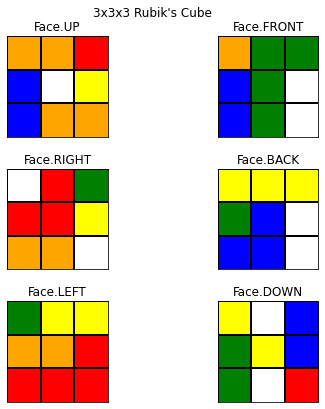

In [4]:
# Render the environment

obs = env.reset()
env.render()

As mentioned, an action consists of specifying a face and an amount to turn it by. We can visualise the impact of an action by using the rendering above.

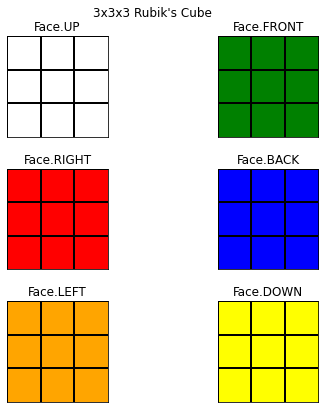

In [5]:
# Don't scramble the cube so it's easier to understand what's happening
env = RubiksCube(step_limit=10, reward_function_type="sparse", num_scrambles_on_reset=0)
obs = env.reset()
env.render()

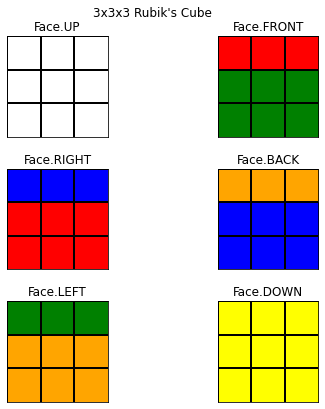

In [6]:
# Turn the UP face clockwise (by 90 degrees)
action = (0, 0)
obs, reward, done, info = env.step(action)
env.render()

By default, the reward function is +1 if the cube is solved, otherwise 0. This is specified by passing reward_function_type to the environment constructor. You can implement your own custom reward function if you think that doing so would better incentivise the agent to learn how to solve the cube! However, be aware that the final evaluation will be purely on how often the cube is solved.

In [7]:
print(f"Reward before solving: {reward}")

# Invert the above action
action = (0, 1)
obs, reward, done, info = env.step(action)
print(f"Reward after solving: {reward}")

Reward before solving: 0.0
Reward after solving: 1.0


The episode can finish for one of two reasons:

1: The cube is solved

2: The step limit is hit. In this case, all rewards throughout the episode will be 0

In [8]:
print(f"Above environment has finished? {done}")

env = RubiksCube(step_limit=10, reward_function_type="sparse", num_scrambles_on_reset=100)
obs = env.reset()
done = False
while not done:
    # Select a random action
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    print(f"New environment has finished? {done}. Reward obtained={reward}")

Above environment has finished? True
New environment has finished? False. Reward obtained=0.0
New environment has finished? False. Reward obtained=0.0
New environment has finished? False. Reward obtained=0.0
New environment has finished? False. Reward obtained=0.0
New environment has finished? False. Reward obtained=0.0
New environment has finished? False. Reward obtained=0.0
New environment has finished? False. Reward obtained=0.0
New environment has finished? False. Reward obtained=0.0
New environment has finished? False. Reward obtained=0.0
New environment has finished? True. Reward obtained=0.0


For some models it might be more helpful to "flatten" the action space, meaning to have a single integer between 0 and 17 rather than a tuple of integers. For this purpose you can use the already implemented wrapper. To get this behaviour in models below, you will typically want to set FLATTEN_ACTIONS to True in training/configs.py

In [9]:
env = create_flattened_env(dict(step_limit=10, reward_function_type="sparse", num_scrambles_on_reset=100))

print(env.action_space)

Discrete(18)


Finally, you can combine multiple frames together to create an animation of your Rubik's Cube!

In [10]:
env = RubiksCube(step_limit=10, reward_function_type="sparse", num_scrambles_on_reset=100)
obs = env.reset()
cubes = [obs["cube"].copy()]
done = False
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    cubes.append(obs["cube"].copy())

anim = env.animation(cubes)
anim.save("cube.gif")

## Training

The algorithm implemented here is Proximal Policy Optimization (PPO), which is an on-policy reinforcement learning algorithm developed by OpenAI. For more information please consult their page: https://openai.com/research/openai-baselines-ppo. Note that one could equally use other algorithms such as DQN and you encouraged to experiment with this, though it may involve changing other parts of the code such as evaluation/generate_rollout.py.

Fundamentally, a PPO agent should implement a policy network and a value network. The policy network maps observations to a parametrisation of the policy that is used to select the next action, whereas the value network maps observations to a single number which is supposed to estimate the expected discounted future reward, and is used to stabilise the training. The model implemented here by default shares most of the parameters between these two networks, though you are encouraged to experiment with different model architectures.

To understand the architecture of the model, examine the model class in training/PPO_models.py. By default it will use FactorisedPPOModel, which takes as input the cube and step count from the observation, and produces an encoding of the observation, which will be a fixed size vector of size given by the final entry of dense_layer_dims in the model_config (defined in training.configs.CUSTOM_MODEL_CONFIG). This encoding is projected to a single number for predicting the value. As for the policy, we take advantage of the factorised/conditional structure of the action space to produce first logits for the decision of which face to turn - the model's face_selection_model. Finally, we compute a conditional distribution by concatenating a sampled value of the selected face (encoded as a one-hot) to the encoding and projecting to give logits for the decision of how much to turn the face - the model's cube_movement_amount_selection_model. This model must be used in combination with the FactorisedActionDistribution.

Note that if one instead flattens the action space this conditional structure will no longer be present and so one should use a different model like FlatPPOModel, and will not need to specify a custom action distribution (since by default PPO is expecting the model to output logits for a flat action space).

### Training your first model

The main training script will write a checkpoint (learned model weights and associated metadata) that you will later be able to use to evaluate training on unseen instances.

This script can also be run from the command line; the following command will execute the same code as the python in the cell below:

python training/example.py --step_limit 10 --reward_function_type sparse --num_scrambles_on_reset 2 --agent_name PPO --num_iterations 2

In [11]:
main_training(
    step_limit=10,
    reward_function_type="sparse",
    num_scrambles_on_reset=2,
    model_config=CUSTOM_MODEL_CONFIG,
    agent_name="PPO",
    num_iterations=2,
    restore_path=None,
)

2023-03-19 00:33:44,317	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


2023-03-19 00:33:46,116	INFO algorithm_config.py:2503 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2023-03-19 00:33:46,120	INFO algorithm_config.py:2503 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2023-03-19 00:33:46,236	WARNING worker.py:837 -- `ray.get_gpu_ids()` will always return the empty list when called from the driver. This is because Ray does not manage GPU allocations to the driver process.
:task_name:bundle_reservation_check_func
:actor_name:PPO
2023-03-19 00:33:46,376	WARNING algorithm_config.py:488 -- Cannot create PPOConfig from given `config_dict`! Property __stdo

:task_name:bundle_reservation_check_func
:actor_name:PPO


:actor_name:RolloutWorker
2023-03-19 00:33:46,522	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


:actor_name:RolloutWorker
Model: "encoding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cube_input (InputLayer)        [(None, 6, 3, 3)]    0           []                               
                                                                                                  
 step_count_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 3, 3, 4)   24          ['cube_input[0][0]']             
                                                                                                  
 tf_op_layer_default_policy_wk1  [(None, 1)]         0           ['step_count_input[0][0]']       
 /truediv (TensorFlowOpLayer)                              

2023-03-19 00:33:47,736	WARNING catalog.py:563 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Total parameters in model: 9884
:actor_name:RolloutWorker


:actor_name:RolloutWorker


Model: "encoding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cube_input (InputLayer)        [(None, 6, 3, 3)]    0           []                               
                                                                                                  
 step_count_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 3, 3, 4)   24          ['cube_input[0][0]']             
                                                                                                  
 tf_op_layer_default_policy_wk2  [(None, 1)]         0           ['step_count_input[0][0]']       
 /truediv (TensorFlowOpLayer)                                                        

2023-03-19 00:33:51,691	WARNING catalog.py:563 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Total parameters in model: 9884
Model: "encoding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cube_input (InputLayer)        [(None, 6, 3, 3)]    0           []                               
                                                                                                  
 step_count_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 3, 3, 4)   24          ['cube_input[0][0]']             
                                                                                                  
 tf_op_layer_default_policy/tru  [(None, 1)]         0           ['step_count_input[0][0]']       
 ediv (TensorFlowOpLayer)                            

2023-03-19 00:33:55,324	WARNING catalog.py:563 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Total parameters in model: 9884


2023-03-19 00:33:58,418	INFO trainable.py:172 -- Trainable.setup took 12.028 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-03-19 00:33:58,421	WARNING util.py:66 -- Install gputil for GPU system monitoring.
:actor_name:PPO


:actor_name:PPO


2023-03-19 00:34:13,861	WARNING util.py:244 -- The `start_trial` operation took 27.610 s, which may be a performance bottleneck.


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


2023-03-19 00:34:28,124	INFO tune.py:762 -- Total run time: 42.37 seconds (41.87 seconds for the tuning loop).


<IPython.core.display.HTML object>
Results are saved to path /root/ray_results/PPO/PPO_rubiks_cube_env_b577b_00000_0_2023-03-19_00-33-46


As you can see there is quite a lot of output! The main highlights are the path to the checkpoint (here the directory is ~/ray_results/PPO/PPO_rubiks_cube_env_f42af_00000_0_2023-02-28_14-55-34), a summary of the model used (which you can override by modifying training/PPO_models.py) and the per iteration results. The latter is a series of metrics summarising what happened during the episode.

You might find it easier to view these in tensorboard:

In [44]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [46]:
%tensorboard --logdir ~/ray_results/PPO/PPO_rubiks_cube_env_d5c24_00000_0_2023-03-19_01-03-18 

Launching TensorBoard...
Please visit http://localhost:8990 in a web browser.


To see some basic documentation of how to use the main training script, run in terminal:

python training/example.py --help

### Training your second model

The library allows you to restore from a checkpoint and continue training, without having to redo the first stages of training. This could be useful in various situations, for example if the training crashed, or if you want to start training on easier environments before progressing to more difficult examples as the agent gets better (curriculum learning). Note that this will only work if the model can stay the same throughout.

Let's restore the checkpoint generated above and continue training on a harder environment. We will increase the number of scrambles done to the cube on reset. Note that we must increase the number of training iterations as otherwise there is nothing to do. The results of this training will be written to a new directory.

This is equivalent to the following command:

python training/example.py --step_limit 10 --reward_function_type sparse --num_scrambles_on_reset 5 --agent_name PPO --num_iterations 4 --restore_path ~/ray_results/PPO/PPO_rubiks_cube_env_f42af_00000_0_2023-02-28_14-55-34/checkpoint_000002

In [15]:
main_training(
    step_limit=10,
    reward_function_type="sparse",
    num_scrambles_on_reset=5,
    model_config=CUSTOM_MODEL_CONFIG,
    agent_name="PPO",
    num_iterations=4,
    restore_path="~/ray_results/PPO/PPO_rubiks_cube_env_b577b_00000_0_2023-03-19_00-33-46/checkpoint_000002/",
)

2023-03-19 00:41:46,409	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


<IPython.core.display.HTML object>
:task_name:bundle_reservation_check_func


:task_name:bundle_reservation_check_func


:actor_name:PPO


:actor_name:PPO


:actor_name:RolloutWorker


:actor_name:RolloutWorker


Model: "encoding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cube_input (InputLayer)        [(None, 6, 3, 3)]    0           []                               
                                                                                                  
 step_count_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 3, 3, 4)   24          ['cube_input[0][0]']             
                                                                                                  
 tf_op_layer_default_policy_wk1  [(None, 1)]         0           ['step_count_input[0][0]']       
 /truediv (TensorFlowOpLayer)                                                        

2023-03-19 00:41:50,357	WARNING catalog.py:563 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Total parameters in model: 9884
:actor_name:RolloutWorker


:actor_name:RolloutWorker


Model: "encoding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cube_input (InputLayer)        [(None, 6, 3, 3)]    0           []                               
                                                                                                  
 step_count_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 3, 3, 4)   24          ['cube_input[0][0]']             
                                                                                                  
 tf_op_layer_default_policy_wk2  [(None, 1)]         0           ['step_count_input[0][0]']       
 /truediv (TensorFlowOpLayer)                                                        

2023-03-19 00:41:53,883	WARNING catalog.py:563 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Total parameters in model: 9884
Model: "encoding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cube_input (InputLayer)        [(None, 6, 3, 3)]    0           []                               
                                                                                                  
 step_count_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 3, 3, 4)   24          ['cube_input[0][0]']             
                                                                                                  
 tf_op_layer_default_policy/tru  [(None, 1)]         0           ['step_count_input[0][0]']       
 ediv (TensorFlowOpLayer)                            

2023-03-19 00:41:56,468	WARNING catalog.py:563 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Total parameters in model: 9884


2023-03-19 00:41:58,869	WARNING util.py:66 -- Install gputil for GPU system monitoring.
:actor_name:PPO


:actor_name:PPO


2023-03-19 00:41:59,209	INFO trainable.py:790 -- Restored on 172.28.0.12 from checkpoint: /tmp/checkpoint_tmp_a48ec385a4ab42c8b3e66167de8078a7
2023-03-19 00:41:59,212	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 28.76213312149048, '_episodes_total': 803}
2023-03-19 00:41:59,228	WARNING util.py:244 -- The `start_trial` operation took 10.264 s, which may be a performance bottleneck.


<IPython.core.display.HTML object>


2023-03-19 00:42:15,931	WARNING util.py:244 -- The `process_trial_restore` operation took 16.690 s, which may be a performance bottleneck.


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


2023-03-19 00:42:32,109	INFO tune.py:762 -- Total run time: 43.37 seconds (43.12 seconds for the tuning loop).


<IPython.core.display.HTML object>
Results are saved to path /root/ray_results/PPO/PPO_rubiks_cube_env_d535c_00000_0_2023-03-19_00-41-48


In [23]:
main_training(
    step_limit=20,
    reward_function_type="sparse",
    num_scrambles_on_reset=5,
    model_config=CUSTOM_MODEL_CONFIG,
    agent_name="PPO",
    num_iterations=10,
    restore_path="~/ray_results/PPO/PPO_rubiks_cube_env_d535c_00000_0_2023-03-19_00-41-48/checkpoint_000004/",
)

2023-03-19 01:03:16,070	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


<IPython.core.display.HTML object>
:task_name:bundle_reservation_check_func


:task_name:bundle_reservation_check_func
:actor_name:PPO


:actor_name:PPO
:actor_name:RolloutWorker


:actor_name:RolloutWorker


Model: "encoding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cube_input (InputLayer)        [(None, 6, 3, 3)]    0           []                               
                                                                                                  
 step_count_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 3, 3, 4)   24          ['cube_input[0][0]']             
                                                                                                  
 tf_op_layer_default_policy_wk1  [(None, 1)]         0           ['step_count_input[0][0]']       
 /truediv (TensorFlowOpLayer)                                                        

2023-03-19 01:03:19,346	WARNING catalog.py:563 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Total parameters in model: 9884
:actor_name:RolloutWorker


:actor_name:RolloutWorker


Model: "encoding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cube_input (InputLayer)        [(None, 6, 3, 3)]    0           []                               
                                                                                                  
 step_count_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 3, 3, 4)   24          ['cube_input[0][0]']             
                                                                                                  
 tf_op_layer_default_policy_wk2  [(None, 1)]         0           ['step_count_input[0][0]']       
 /truediv (TensorFlowOpLayer)                                                        

2023-03-19 01:03:23,013	WARNING catalog.py:563 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Total parameters in model: 9884
Model: "encoding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cube_input (InputLayer)        [(None, 6, 3, 3)]    0           []                               
                                                                                                  
 step_count_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 3, 3, 4)   24          ['cube_input[0][0]']             
                                                                                                  
 tf_op_layer_default_policy/tru  [(None, 1)]         0           ['step_count_input[0][0]']       
 ediv (TensorFlowOpLayer)                            

2023-03-19 01:03:26,637	WARNING catalog.py:563 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Total parameters in model: 9884


2023-03-19 01:03:30,107	INFO trainable.py:172 -- Trainable.setup took 11.607 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-03-19 01:03:30,110	WARNING util.py:66 -- Install gputil for GPU system monitoring.
:actor_name:PPO


:actor_name:PPO


2023-03-19 01:03:30,478	INFO trainable.py:790 -- Restored on 172.28.0.12 from checkpoint: /tmp/checkpoint_tmp_395481b3ea494eb4bbacc615b17a5ef7
2023-03-19 01:03:30,480	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 61.035794496536255, '_episodes_total': 1603}
2023-03-19 01:03:30,497	WARNING util.py:244 -- The `start_trial` operation took 12.126 s, which may be a performance bottleneck.


<IPython.core.display.HTML object>


2023-03-19 01:03:45,757	WARNING util.py:244 -- The `process_trial_restore` operation took 15.241 s, which may be a performance bottleneck.


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


2023-03-19 01:05:00,457	INFO tune.py:762 -- Total run time: 102.28 seconds (102.10 seconds for the tuning loop).


<IPython.core.display.HTML object>
Results are saved to path /root/ray_results/PPO/PPO_rubiks_cube_env_d5c24_00000_0_2023-03-19_01-03-18


In [31]:
main_training(
    step_limit=20,
    reward_function_type="sparse",
    num_scrambles_on_reset=8,
    model_config=CUSTOM_MODEL_CONFIG,
    agent_name="PPO",
    num_iterations=10,
    restore_path="~/ray_results/PPO/PPO_rubiks_cube_env_d5c24_00000_0_2023-03-19_01-03-18/checkpoint_000006/",
)

2023-03-19 01:21:40,819	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


<IPython.core.display.HTML object>
:task_name:bundle_reservation_check_func


:task_name:bundle_reservation_check_func
:actor_name:PPO


:actor_name:PPO
:actor_name:RolloutWorker


:actor_name:RolloutWorker


Model: "encoding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cube_input (InputLayer)        [(None, 6, 3, 3)]    0           []                               
                                                                                                  
 step_count_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 3, 3, 4)   24          ['cube_input[0][0]']             
                                                                                                  
 tf_op_layer_default_policy_wk1  [(None, 1)]         0           ['step_count_input[0][0]']       
 /truediv (TensorFlowOpLayer)                                                        

2023-03-19 01:21:43,661	WARNING catalog.py:563 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Total parameters in model: 9884
:actor_name:RolloutWorker


:actor_name:RolloutWorker


Model: "encoding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cube_input (InputLayer)        [(None, 6, 3, 3)]    0           []                               
                                                                                                  
 step_count_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 3, 3, 4)   24          ['cube_input[0][0]']             
                                                                                                  
 tf_op_layer_default_policy_wk2  [(None, 1)]         0           ['step_count_input[0][0]']       
 /truediv (TensorFlowOpLayer)                                                        

2023-03-19 01:21:46,397	WARNING catalog.py:563 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Total parameters in model: 9884
Model: "encoding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cube_input (InputLayer)        [(None, 6, 3, 3)]    0           []                               
                                                                                                  
 step_count_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 3, 3, 4)   24          ['cube_input[0][0]']             
                                                                                                  
 tf_op_layer_default_policy/tru  [(None, 1)]         0           ['step_count_input[0][0]']       
 ediv (TensorFlowOpLayer)                            

2023-03-19 01:21:49,070	WARNING catalog.py:563 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Total parameters in model: 9884


2023-03-19 01:21:51,984	WARNING util.py:66 -- Install gputil for GPU system monitoring.
:actor_name:PPO


:actor_name:PPO


2023-03-19 01:21:52,521	INFO trainable.py:790 -- Restored on 172.28.0.12 from checkpoint: /tmp/checkpoint_tmp_a9e7d1e42afe42deaa9d654f156448eb
2023-03-19 01:21:52,524	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 89.82298040390015, '_episodes_total': 2003}
2023-03-19 01:21:52,537	WARNING util.py:244 -- The `start_trial` operation took 9.601 s, which may be a performance bottleneck.


<IPython.core.display.HTML object>


2023-03-19 01:22:07,867	WARNING util.py:244 -- The `process_trial_restore` operation took 15.304 s, which may be a performance bottleneck.


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


2023-03-19 01:22:53,245	INFO tune.py:762 -- Total run time: 70.51 seconds (70.28 seconds for the tuning loop).


<IPython.core.display.HTML object>
Results are saved to path /root/ray_results/PPO/PPO_rubiks_cube_env_68218_00000_0_2023-03-19_01-21-42


Note that only 2 additional iterations of training were performed.

There is a lot more customisablity available for rllib, feel free to consult documentation at https://docs.ray.io/en/latest/rllib/index.html

## Evaluation

The final stage to is to produce a set of rollouts - that is sequences of actions and new observations that one obtains by repeatedly inferring from a model and taking the corresponding action in the environment. Included below is a simple set of commands that are likely to be useful if you would like to investigate the decisions that your model is making in particular situations.

In [32]:
config = get_config(
    env_config=MEDIUM_ENV_CONFIG,
    model_config=CUSTOM_MODEL_CONFIG,
    agent_name="PPO",
)
register(agent_name="PPO")
with _ray():
    agent = PPO(AlgorithmConfig.from_dict(config))
    agent.restore("/root/ray_results/PPO/PPO_rubiks_cube_env_68218_00000_0_2023-03-19_01-21-42/checkpoint_000008/")
    env = RubiksCube(**MEDIUM_ENV_CONFIG)
    obs = env.reset()
    # Exploration means to sample from the parametrised distribution. Setting it to false picks the modal action
    action = agent.compute_single_action(observation=obs, explore=False)

2023-03-19 01:24:39,303	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


:actor_name:RolloutWorker


:actor_name:RolloutWorker


Model: "encoding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cube_input (InputLayer)        [(None, 6, 3, 3)]    0           []                               
                                                                                                  
 step_count_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 3, 3, 4)   24          ['cube_input[0][0]']             
                                                                                                  
 tf_op_layer_default_policy_wk1  [(None, 1)]         0           ['step_count_input[0][0]']       
 /truediv (TensorFlowOpLayer)                                                        

2023-03-19 01:24:42,065	WARNING catalog.py:563 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Total parameters in model: 9884
:actor_name:RolloutWorker


:actor_name:RolloutWorker


Model: "encoding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cube_input (InputLayer)        [(None, 6, 3, 3)]    0           []                               
                                                                                                  
 step_count_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 3, 3, 4)   24          ['cube_input[0][0]']             
                                                                                                  
 tf_op_layer_default_policy_wk2  [(None, 1)]         0           ['step_count_input[0][0]']       
 /truediv (TensorFlowOpLayer)                                                        

2023-03-19 01:24:45,115	WARNING catalog.py:563 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Total parameters in model: 9884
Model: "encoding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cube_input (InputLayer)        [(None, 6, 3, 3)]    0           []                               
                                                                                                  
 step_count_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 3, 3, 4)   24          ['cube_input[0][0]']             
                                                                                                  
 tf_op_layer_default_policy/tru  [(None, 1)]         0           ['step_count_input[0][0]']       
 ediv (TensorFlowOpLayer)                            

2023-03-19 01:24:50,664	WARNING catalog.py:563 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Total parameters in model: 9884


2023-03-19 01:24:54,526	INFO trainable.py:172 -- Trainable.setup took 13.324 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-03-19 01:24:54,529	WARNING util.py:66 -- Install gputil for GPU system monitoring.
2023-03-19 01:24:54,990	INFO trainable.py:790 -- Restored on 172.28.0.12 from checkpoint: /root/ray_results/PPO/PPO_rubiks_cube_env_68218_00000_0_2023-03-19_01-21-42/checkpoint_000008
2023-03-19 01:24:54,992	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': None, '_time_total': 120.2462511062622, '_episodes_total': 2403}


In [33]:
env.render()

Figure(432x432)


In [34]:
action

(1, 2)

In [35]:
print(f"Agent is choosing action {action}")
obs, reward, done, info = env.step(action)

Agent is choosing action (1, 2)


In [36]:
env.render()

Figure(432x432)


For a more systematic way of doing this, there is a script which will run this automatically on a collection of increasingly difficult environment configurations and write the result to a file. To use this script, run:

python evaluation/generate_rollout.py

while specifying command line arguments checkpoint_path (indicating the path to restore from if using a trained model), the results_path (where to write the results of the inference to), and the agent_name (can leave blank if using PPO).

In [37]:
# Example on a smaller set of seeds

main_rollout(seeds=PUBLIC_SEEDS,
             checkpoint_path="/root/ray_results/PPO/PPO_rubiks_cube_env_68218_00000_0_2023-03-19_01-21-42/checkpoint_000008/", 
             results_path="sample_results.txt")

2023-03-19 01:25:04,496	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Generating rollouts for easy env config...
:actor_name:RolloutWorker


:actor_name:RolloutWorker


Model: "encoding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cube_input (InputLayer)        [(None, 6, 3, 3)]    0           []                               
                                                                                                  
 step_count_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 3, 3, 4)   24          ['cube_input[0][0]']             
                                                                                                  
 tf_op_layer_default_policy_wk1  [(None, 1)]         0           ['step_count_input[0][0]']       
 /truediv (TensorFlowOpLayer)                                                        

2023-03-19 01:25:08,953	WARNING catalog.py:563 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Total parameters in model: 9884
:actor_name:RolloutWorker


:actor_name:RolloutWorker


Model: "encoding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cube_input (InputLayer)        [(None, 6, 3, 3)]    0           []                               
                                                                                                  
 step_count_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 3, 3, 4)   24          ['cube_input[0][0]']             
                                                                                                  
 tf_op_layer_default_policy_wk2  [(None, 1)]         0           ['step_count_input[0][0]']       
 /truediv (TensorFlowOpLayer)                                                        

2023-03-19 01:25:12,600	WARNING catalog.py:563 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Total parameters in model: 9884
Model: "encoding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cube_input (InputLayer)        [(None, 6, 3, 3)]    0           []                               
                                                                                                  
 step_count_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 3, 3, 4)   24          ['cube_input[0][0]']             
                                                                                                  
 tf_op_layer_default_policy/tru  [(None, 1)]         0           ['step_count_input[0][0]']       
 ediv (TensorFlowOpLayer)                            

2023-03-19 01:25:16,311	WARNING catalog.py:563 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Total parameters in model: 9884


2023-03-19 01:25:18,768	INFO trainable.py:172 -- Trainable.setup took 11.213 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-03-19 01:25:18,772	WARNING util.py:66 -- Install gputil for GPU system monitoring.
2023-03-19 01:25:19,112	INFO trainable.py:790 -- Restored on 172.28.0.12 from checkpoint: /root/ray_results/PPO/PPO_rubiks_cube_env_68218_00000_0_2023-03-19_01-21-42/checkpoint_000008
2023-03-19 01:25:19,114	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': None, '_time_total': 120.2462511062622, '_episodes_total': 2403}


Generating rollouts for medium env config...
:actor_name:RolloutWorker


:actor_name:RolloutWorker


Model: "encoding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cube_input (InputLayer)        [(None, 6, 3, 3)]    0           []                               
                                                                                                  
 step_count_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 3, 3, 4)   24          ['cube_input[0][0]']             
                                                                                                  
 tf_op_layer_default_policy_wk1  [(None, 1)]         0           ['step_count_input[0][0]']       
 /truediv (TensorFlowOpLayer)                                                        

2023-03-19 01:25:37,924	WARNING catalog.py:563 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Total parameters in model: 9884
:actor_name:RolloutWorker


:actor_name:RolloutWorker


Model: "encoding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cube_input (InputLayer)        [(None, 6, 3, 3)]    0           []                               
                                                                                                  
 step_count_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 3, 3, 4)   24          ['cube_input[0][0]']             
                                                                                                  
 tf_op_layer_default_policy_wk2  [(None, 1)]         0           ['step_count_input[0][0]']       
 /truediv (TensorFlowOpLayer)                                                        

2023-03-19 01:25:40,639	WARNING catalog.py:563 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Total parameters in model: 9884
Model: "encoding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cube_input (InputLayer)        [(None, 6, 3, 3)]    0           []                               
                                                                                                  
 step_count_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 3, 3, 4)   24          ['cube_input[0][0]']             
                                                                                                  
 tf_op_layer_default_policy/tru  [(None, 1)]         0           ['step_count_input[0][0]']       
 ediv (TensorFlowOpLayer)                            

2023-03-19 01:25:43,326	WARNING catalog.py:563 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Total parameters in model: 9884


2023-03-19 01:25:45,621	WARNING util.py:66 -- Install gputil for GPU system monitoring.
2023-03-19 01:25:45,933	INFO trainable.py:790 -- Restored on 172.28.0.12 from checkpoint: /root/ray_results/PPO/PPO_rubiks_cube_env_68218_00000_0_2023-03-19_01-21-42/checkpoint_000008
2023-03-19 01:25:45,934	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': None, '_time_total': 120.2462511062622, '_episodes_total': 2403}


Generating rollouts for hard env config...
:actor_name:RolloutWorker


:actor_name:RolloutWorker


Model: "encoding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cube_input (InputLayer)        [(None, 6, 3, 3)]    0           []                               
                                                                                                  
 step_count_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 3, 3, 4)   24          ['cube_input[0][0]']             
                                                                                                  
 tf_op_layer_default_policy_wk1  [(None, 1)]         0           ['step_count_input[0][0]']       
 /truediv (TensorFlowOpLayer)                                                        

2023-03-19 01:26:09,638	WARNING catalog.py:563 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Total parameters in model: 9884
:actor_name:RolloutWorker


:actor_name:RolloutWorker


Model: "encoding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cube_input (InputLayer)        [(None, 6, 3, 3)]    0           []                               
                                                                                                  
 step_count_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 3, 3, 4)   24          ['cube_input[0][0]']             
                                                                                                  
 tf_op_layer_default_policy_wk2  [(None, 1)]         0           ['step_count_input[0][0]']       
 /truediv (TensorFlowOpLayer)                                                        

2023-03-19 01:26:13,255	WARNING catalog.py:563 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Total parameters in model: 9884
Model: "encoding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cube_input (InputLayer)        [(None, 6, 3, 3)]    0           []                               
                                                                                                  
 step_count_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 3, 3, 4)   24          ['cube_input[0][0]']             
                                                                                                  
 tf_op_layer_default_policy/tru  [(None, 1)]         0           ['step_count_input[0][0]']       
 ediv (TensorFlowOpLayer)                            

2023-03-19 01:26:16,978	WARNING catalog.py:563 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Total parameters in model: 9884


2023-03-19 01:26:19,532	INFO trainable.py:172 -- Trainable.setup took 10.531 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-03-19 01:26:19,535	WARNING util.py:66 -- Install gputil for GPU system monitoring.
2023-03-19 01:26:19,845	INFO trainable.py:790 -- Restored on 172.28.0.12 from checkpoint: /root/ray_results/PPO/PPO_rubiks_cube_env_68218_00000_0_2023-03-19_01-21-42/checkpoint_000008
2023-03-19 01:26:19,848	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': None, '_time_total': 120.2462511062622, '_episodes_total': 2403}


Finally, you can run the script python evaluation/validate_rollout.py to make sure that the results are given in a format the platform can understand. For more information on how to use this script, run python evaluation/validate_rollout.py --help

In [38]:
score = main_validation(results_path="sample_results.txt", public_seeds=PUBLIC_SEEDS)
print(f"You scored {score}!")

Validating rollouts on easy difficulty...


100%|██████████| 257110/257110 [01:34<00:00, 2723.71it/s]


Validating rollouts on medium difficulty...


100%|██████████| 257110/257110 [03:22<00:00, 1268.69it/s]


Validating rollouts on hard difficulty...


100%|██████████| 257110/257110 [04:03<00:00, 1053.87it/s]

You scored 0.03183333333333333!
